In [14]:
import pickle
import sys
import os

sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

import rioxarray as rxr
import xarray as xr
import geopandas as gpd

# Applying to elephants

In [81]:
# Parameters
model_to_use = 'pymer' # "pymer" or "rf" or "xgboost"
species = 'asian' # "african forest" or "african savannah" or "asian"
save_raster = False

In [82]:
# Read in the predictor raster stack
predictor_stack_fp = '/Users/emiliolr/Google Drive/My Drive/LIFE/datasets/derived_datasets/hunting_predictor_stack/hunting_predictor_stack_buffered.tif'
predictor_stack = rxr.open_rasterio(predictor_stack_fp)

#  turning into a dataset w/the correct variable names
predictor_stack = predictor_stack.to_dataset(dim = 'band')
new_names = {i + 1 : l for i, l in enumerate(predictor_stack.long_name)}
predictor_stack = predictor_stack.rename_vars(new_names)

predictor_stack

<xarray.Dataset> Size: 2GB
Dimensions:                  (y: 4195, x: 15985)
Coordinates:
  * x                        (x) float64 128kB -110.4 -110.4 ... 155.9 156.0
  * y                        (y) float64 34kB 34.99 34.97 ... -34.89 -34.91
    spatial_ref              int64 8B 0
Data variables:
    Dist_Settlement_KM       (y, x) float32 268MB ...
    Stunting_Pct             (y, x) float32 268MB ...
    Literacy_Rate            (y, x) float32 268MB ...
    Travel_Time_Large        (y, x) float32 268MB ...
    Livestock_Biomass        (y, x) float32 268MB ...
    Population_Density       (y, x) float32 268MB ...
    Percent_Settlement_50km  (y, x) float32 268MB ...
    Protected_Area           (y, x) float32 268MB ...
Attributes:
    AREA_OR_POINT:       Area
    STATISTICS_MAXIMUM:  353306.875
    STATISTICS_MEAN:     -9999
    STATISTICS_MINIMUM:  0
    STATISTICS_STDDEV:   -9999
    _FillValue:          nan
    scale_factor:        1.0
    add_offset:          0.0
    long_name:           ('Dist_Settlement_KM', 'Stunting_Pct', 'Literacy_Rat...

In [83]:
# Reading the tropical forest extent polygon for masking non-forest pixels
tropical_zone_fp = '/Users/emiliolr/Google Drive/My Drive/LIFE/datasets/derived_datasets/tropical_forest_extent/tropical_forest_extent.shp'

tropical_zone = gpd.read_file(tropical_zone_fp)
tropical_zone = [tropical_zone.geometry.iloc[0]]

In [84]:
# Reading the full mammal_recreated dataset for z-score stats
mammals_data_fp = '/Users/emiliolr/Google Drive/My Drive/LIFE/datasets/derived_datasets/benitez_lopez2019_recreated/benitez_lopez2019_recreated_w_original.csv'
mammals_data = pd.read_csv(mammals_data_fp)

#  columns to use
cols_to_normalize = list(predictor_stack.long_name)
cols_to_normalize.remove('Protected_Area')

#  extract columns means + standard deviations
mammals_cols_to_normalize = mammals_data[cols_to_normalize]
if model_to_use == 'pymer':
    mammals_cols_to_normalize = mammals_cols_to_normalize.replace(0, 0.1)
    mammals_cols_to_normalize = np.log10(mammals_cols_to_normalize)
    
col_means = mammals_cols_to_normalize.mean(axis = 0)
col_stds = mammals_cols_to_normalize.std(axis = 0)

In [85]:
# Applying data preprocessing
for pred in cols_to_normalize:
    temp = predictor_stack[pred]
    
    if pred == 'Dist_Settlement_KM':
        temp = temp / 1000 # converting to actual km

    #  log10-transforming continuous vars (just linear hurdle)
    if model_to_use == 'pymer':
        temp = temp.where(temp != 0, other = 0.1) # making sure there aren't issues w/taking the log
        temp = xr.ufuncs.log10(temp)
    
    #  z-score normalization
    temp = temp - col_means[pred]
    temp = temp / col_stds[pred]

    #  slotting the preprocessed version back into the dataset
    predictor_stack[pred] = temp

In [86]:
# Read in the saved predictive model
model_base_path = '/Users/emiliolr/Google Drive/My Drive/LIFE/hunting_analysis/final_models'
model_fps = {'rf' : 'rf_hurdle_10.0mins.pkl',
             'xgboost' : 'xgboost_hurdle_10.0mins.pkl',
             'pymer' : 'pymer_hurdle.pkl'}

model_fp = os.path.join(model_base_path, model_fps[model_to_use])

with open(model_fp, 'rb') as f:
    model = pickle.load(f)

model

HurdleModelEstimator(data_args={'dataset': 'mammals_recreated',
                                'outlier_cutoff': 5.0,
                                'rebalance_dataset': False},
                     extirp_pos=False,
                     nonzero_model=<model_utils.PymerModelWrapper object at 0x4bea65eb0>,
                     prob_thresh=0.9, verbose=True,
                     zero_model=<model_utils.PymerModelWrapper object at 0x17597aab0>)

In [87]:
# Reading in the relevant elephant AOH
aoh_base_fp = '/Users/emiliolr/Desktop/phd-exploratory-work/data/elephants'
aoh_fps = {'african forest' : '181007989_RESIDENT.tif',
           'african savannah' : '181008073_RESIDENT.tif', 
           'asian' : '7140_RESIDENT.tif'}

aoh_fp = os.path.join(aoh_base_fp, aoh_fps[species])
aoh = rxr.open_rasterio(aoh_fp)

aoh

<xarray.DataArray (band: 1, y: 2182, x: 2688)> Size: 23MB
[5865216 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 22kB 74.16 74.18 74.19 74.21 ... 118.9 118.9 118.9
  * y            (y) float64 17kB 30.41 30.4 30.38 ... -5.904 -5.921 -5.938
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [88]:
# Clipping the predictor rasters to the bounds of the AOH
predictor_stack_clipped = predictor_stack.rio.clip_box(*aoh.rio.bounds())

#  making sure the predictor stack is perfectly aligned w/AOH
predictor_stack_clipped = predictor_stack_clipped.rio.reproject_match(aoh)

#  zeroing out the bits of the predictors which AREN'T in the species' AOH
predictor_stack_clipped = predictor_stack_clipped.where(aoh != 0)

In [89]:
# Extracting the data to numpy + reshaping to get it in a "tabular" format
predictor_stack_np = predictor_stack_clipped.to_array().variable.values.squeeze()
num_y, num_x = predictor_stack_np[0].shape
predictors_tabular = predictor_stack_np.reshape(predictor_stack_np.shape[0], num_y * num_x).transpose()
print(f'Originally {predictors_tabular.shape[0]} pixels to predict on')

#  tossing nan rows, but keeping track of where they are for reshaping back to raster later
nan_mask = np.any(np.isnan(predictors_tabular), axis = 1)
predictors_tabular_no_nan = predictors_tabular[~nan_mask, : ]

pixels_left = predictors_tabular_no_nan.shape[0]
print(f'Now only {pixels_left} pixels to predict on')

#  checking if we drop any pixels within the AOH
aoh_total_pixels = float((aoh != 0).sum())
if pixels_left < aoh_total_pixels:
    print()
    print(f'DROPPED {int(aoh_total_pixels - pixels_left)} PIXELS!')

Originally 5865216 pixels to predict on
Now only 165007 pixels to predict on

DROPPED 58 PIXELS!


In [90]:
# Putting data in a Pandas DataFrame so the predict function of the hurdle model can grab the right vars
predictors_tabular_no_nan = pd.DataFrame(predictors_tabular_no_nan, columns = predictor_stack_clipped.long_name)

#  adding the same body mass value to each row - African forest elephant
#   - EltonTraits only has the combined "African elephant", before species were split
body_masses = {'african forest' : 3940.03 * 1000,
               'african savannah' : 3940.03 * 1000,
               'asian' : 2915.04 * 1000}

if model_to_use == 'pymer':
    bm = np.log10(mammals_data['Body_Mass'])
    bm_mean, bm_std = bm.mean(), bm.std()
    
    elephant_body_mass = (np.log10(body_masses[species]) - bm_mean) / bm_std
else:
    bm = mammals_data['Body_Mass']
    bm_mean, bm_std = bm.mean(), bm.std()
    
    elephant_body_mass = (body_masses[species] - bm_mean) / bm_std

predictors_tabular_no_nan['Body_Mass'] = elephant_body_mass

#  apply the trained hurdle model to each pixel iteratively
pred = model.predict(predictors_tabular_no_nan)
pred[pred != 0] = np.exp(pred[pred != 0]) # back-transforming log RRs

In [91]:
# Putting the dataset all back together in a predicted raster
pred_tabular = np.empty(shape = predictors_tabular.shape[0])
pred_tabular.fill(np.nan)
pred_tabular[~nan_mask] = pred # one prediction for each pixel, w/nans put back in the right place

#  reshaping back to raster format + converting back to xarray
pred_raster = pred_tabular.transpose().reshape(num_y, num_x)
pred_raster_xr = xr.zeros_like(aoh)
pred_raster_xr.values = np.expand_dims(pred_raster, axis = 0)

#  masking predictions outside of the tropical forest zone
pred_raster_xr = pred_raster_xr.rio.clip(tropical_zone)

pred_raster_xr

<xarray.DataArray (band: 1, y: 2182, x: 2688)> Size: 47MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 22kB 74.16 74.18 74.19 74.21 ... 118.9 118.9 118.9
  * y            (y) float64 17kB 30.41 30.4 30.38 ... -5.904 -5.921 -5.938
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

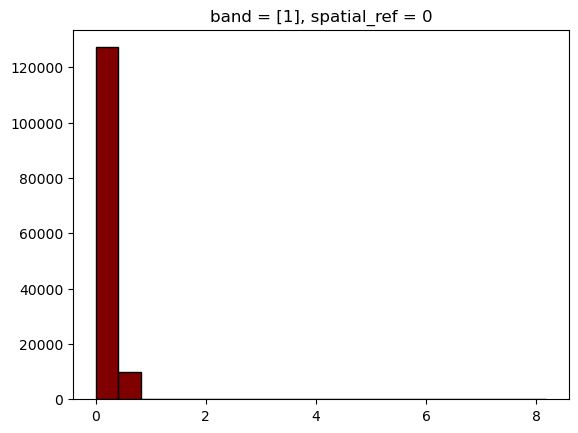

In [92]:
# Quick look at the distribution of predicted RR values
pred_raster_xr.plot.hist(bins = 20, color = 'maroon', edgecolor = 'black')
plt.show()

In [93]:
# Saving back to TIF using rasterio
if save_raster:
    species_name = species.replace(' ', '_')
    pred_raster_xr.rio.to_raster(f'/Users/emiliolr/Desktop/phd-exploratory-work/results/elephants/predicted_raster_{species_name}_{model_to_use}.tif', dtype = 'float32')

# Proof of concept of applying pressure map to AOH

In [94]:
# What portion of the AOH's pixels has predictions?
aoh_num_pixels = float((aoh != 0).sum())
pixels_w_preds = float(((aoh != 0) & (~xr.ufuncs.isnan(pred_raster_xr))).sum())

print(f'{round(pixels_w_preds / aoh_num_pixels * 100, 2)}% of pixels in the AOH have hunting predictions')

83.08% of pixels in the AOH have hunting predictions


In [95]:
# Putting ones (no hunting effect) in locations with no predictions
no_pred_mask = ((aoh != 0) & (xr.ufuncs.isnan(pred_raster_xr)))
test = pred_raster_xr.where(~no_pred_mask, other = 1)

In [96]:
# Elementwise multiplication with AOH raster, now not binarizing
cur_aoh = float(aoh.sum()) / (1000 * 1000) # convert to KM^2
aoh_w_hunting = float((aoh * test).sum()) / (1000 * 1000)

pct_change = (aoh_w_hunting - cur_aoh) / cur_aoh
print(f'{round(pct_change * 100, 2)}% change in AOH due to hunting')

-92.64% change in AOH due to hunting


# Initial testing (toy example)

In [25]:
# Reading arbitrary raster data to fit the model to, just as an example
forest_cover_fp = '/Users/emiliolr/Google Drive/My Drive/LIFE/datasets/environmental_predictors/forest_cover/hansen2013/hansen_forest_cover_2000.tif'
pop_dens_fp = '/Users/emiliolr/Google Drive/My Drive/LIFE/datasets/socioeconomic_predictors/human_population_density/gpw-v4/gpw-v4-population-density-rev11_2000_30_sec_tif/gpw_v4_population_density_rev11_2000_30_sec.tif'

forest_cover = rxr.open_rasterio(forest_cover_fp)
pop_dens = rxr.open_rasterio(pop_dens_fp)

#  resampling population density to match forest cover
pop_dens_resampled = pop_dens.rio.reproject_match(forest_cover)
pop_dens_resampled = pop_dens_resampled.where(pop_dens_resampled > 0) # replacing fill values w/nan

In [26]:
# Stacking the two datasets, making sure they align
predictor_stack = forest_cover.to_dataset(name = 'forest_cover')
predictor_stack['pop_dens'] = pop_dens_resampled

predictor_stack

<xarray.Dataset> Size: 4GB
Dimensions:       (band: 1, x: 40076, y: 20039)
Coordinates:
  * band          (band) int64 8B 1
  * x             (x) float64 321kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * y             (y) float64 160kB 90.0 89.99 89.98 ... -89.98 -89.99 -90.0
    spatial_ref   int64 8B 0
Data variables:
    forest_cover  (band, y, x) uint8 803MB ...
    pop_dens      (band, y, x) float32 3GB nan nan nan nan ... nan nan nan nan

In [27]:
# Define linear regression model, just to test applying an sklearn model
lr = LinearRegression()

#  setting coefficients, not fitting them... imagining we have a pre-trained model
lr.coef_ = np.array([3, 5])
lr.intercept_ = np.array([10])
lr.n_features_in_ = 2

#  checking that prediction works as expected on an arbitrary array
a = np.array([[1, 2], [1, 2], [5, 6]])
lr.predict(a)

array([23, 23, 55])

In [28]:
# Read in an example AOH over which to apply the model
ex_aoh_fp = '/Users/emiliolr/Desktop/phd-exploratory-work/data/62774969_NONBREEDING.tif'
ex_aoh = rxr.open_rasterio(ex_aoh_fp)

ex_aoh

<xarray.DataArray (band: 1, y: 6008, x: 12403)> Size: 298MB
[74517224 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 99kB -28.82 -28.81 -28.79 ... 177.8 177.9 177.9
  * y            (y) float64 48kB 55.11 55.1 55.08 55.06 ... -44.97 -44.99 -45.0
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        3419176.5
    STATISTICS_MEAN:           4998.1130199837
    STATISTICS_MINIMUM:        0
    STATISTICS_STDDEV:         90552.637185603
    STATISTICS_VALID_PERCENT:  100
    scale_factor:              1.0
    add_offset:                0.0

In [29]:
# Clipping the predictor rasters to the bounds of the AOH + reprojecting to be sure they align
predictor_stack_clipped = predictor_stack.rio.clip_box(*ex_aoh.rio.bounds())
predictor_stack_clipped = predictor_stack_clipped.rio.reproject_match(ex_aoh)
predictor_stack_clipped

<xarray.Dataset> Size: 373MB
Dimensions:       (band: 1, x: 12403, y: 6008)
Coordinates:
  * band          (band) int64 8B 1
    spatial_ref   int64 8B 0
  * x             (x) float64 99kB -28.82 -28.81 -28.79 ... 177.8 177.9 177.9
  * y             (y) float64 48kB 55.11 55.1 55.08 ... -44.97 -44.99 -45.0
Data variables:
    forest_cover  (band, y, x) uint8 75MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    pop_dens      (band, y, x) float32 298MB nan nan nan nan ... nan nan nan nan

In [30]:
# Zeroing out the bits of the area which AREN'T in the species' AOH
predictor_stack_clipped = predictor_stack_clipped.where(ex_aoh != 0)

In [31]:
# Extracting the data to numpy + reshaping to get it in a "tabular" format
predictor_stack_np = predictor_stack_clipped.to_array().variable.values.squeeze()
num_y, num_x = predictor_stack_np[0].shape
predictors_tabular = predictor_stack_np.reshape(predictor_stack_np.shape[0], num_y * num_x).transpose()
print(f'Originally {predictors_tabular.shape[0]} pixels to predict on')

#  tossing nan rows, but keeping track of where they are for reshaping back to raster later
nan_mask = np.any(np.isnan(predictors_tabular), axis = 1)
predictors_tabular_no_nan = predictors_tabular[~nan_mask, : ]
print(f'Now only {predictors_tabular_no_nan.shape[0]} pixels to predict on')

Originally 74517224 pixels to predict on
Now only 799719 pixels to predict on


In [35]:
# Apply the "trained" regression model to each pixel iteratively
#  - see this tutorial: https://rse.shef.ac.uk/blog/xarray-for-earth/
#  - for parallelizing predictions: batch data (into many chunks) + use parallel functionality from Joblib?
pred = lr.predict(predictors_tabular_no_nan)

In [37]:
# Putting the dataset all back together in a predicted raster
pred_tabular = np.empty(shape = predictors_tabular.shape[0])
pred_tabular.fill(np.nan)
pred_tabular[~nan_mask] = pred # one prediction for each pixel, w/nans put back in the right place

#  reshaping back to raster format + converting back to xarray
pred_raster = pred_tabular.transpose().reshape(num_y, num_x)
pred_raster_xr = xr.zeros_like(ex_aoh)
pred_raster_xr.values = np.expand_dims(pred_raster, axis = 0)

pred_raster_xr

<xarray.DataArray (band: 1, y: 6008, x: 12403)> Size: 596MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 99kB -28.82 -28.81 -28.79 ... 177.8 177.9 177.9
  * y            (y) float64 48kB 55.11 55.1 55.08 55.06 ... -44.97 -44.99 -45.0
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        3419176.5
    STATISTICS_MEAN:           4998.1130199837
    STATISTICS_MINIMUM:        0
    STATISTICS_STDDEV:         90552.637185603
    STATISTICS_VALID_PERCENT:  100
    scale_factor:              1.0
    add_offset:                0.0

In [177]:
# Saving back to TIF using rasterio
pred_raster_xr.rio.to_raster('../results/testing/predicted_raster.tif', dtype = 'float32')

# Proof of concept-ing

In [22]:
# Proof of concept of how to deal w/nans in prediction, which arise naturally b/c of, e.g., 
#  oceans or area outside of AOH w/in raster bbox but are needed to recover shape of final raster
b = np.array([[1, 2], [np.nan, 3], [5, 6]]) # here, rows are each a pixel

#  remove nans, for prediction
nan_mask = np.any(np.isnan(b), axis = 1)
b_wo_nan = b[~nan_mask, : ]

#  predict on this data subset
b_preds = lr.predict(b_wo_nan)
print(b_preds)

#  after prediction, put nan rows back
b_post_pred = np.empty(shape = b.shape[0])
b_post_pred.fill(np.nan)

b_post_pred[~nan_mask] = b_preds # one prediction for each pixel, w/nans put back in the right place
print(b_post_pred)

[23. 55.]
[23. nan 55.]


In [39]:
# Sanity check: does the reshaping to "tabular" from stacked rasters work as expected?
#  - dummy example w/two 3x3 "rasters"
a = np.array([[[1, 2, 3], [4, 5, 6], [7, 8, 9]], [[9, 8, 7], [6, 5, 4], [3, 2, 1]]])
a_tab = a.reshape(a.shape[0], a.shape[1] * a.shape[2]).transpose()

print(a)
print()
print(a_tab)

[[[1 2 3]
  [4 5 6]
  [7 8 9]]

 [[9 8 7]
  [6 5 4]
  [3 2 1]]]

[[1 9]
 [2 8]
 [3 7]
 [4 6]
 [5 5]
 [6 4]
 [7 3]
 [8 2]
 [9 1]]


In [41]:
# Sanity check: does reversing the reshaping work as intended?
a_pred = (1 * a_tab[ : , 0]) + (2 * a_tab[ : , 1])
a_pred_raster = a_pred.transpose().reshape(a.shape[1], a.shape[2])

print(a_pred)
print()
print(a_pred_raster)

[19 18 17 16 15 14 13 12 11]

[[19 18 17]
 [16 15 14]
 [13 12 11]]
